### Convolutional Variational Autoencoder to generate bird images
The goal of the below presented neural network is to implement a variational autoencoder for bird images from CIFAR-10 database. This implementation uses convolutional (and transpose convolutional) layers, four of them.


In [2]:
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, Reshape, Conv2DTranspose
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, EarlyStopping, ModelCheckpoint

In [3]:
# Loading the original dataset

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

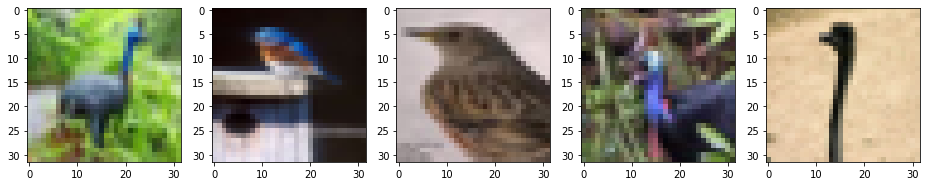

In [4]:
# Filtering out everything except birds

# cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
filtered_images      = [ X_train[i] for i in range(len(X_train)) if y_train[i][0] == 2 ]
filtered_images_test = [ X_test[i] for i in range(len(X_test)) if y_test[i][0] == 2 ]

# Checking the first five image
fig, img_array = plt.subplots(1, 5)
fig.set_size_inches(16, 6)

for i in range(5):
    img_array[i].imshow(filtered_images[i])
plt.show()

In [5]:
# Preprocessing the bird images

filtered_images = np.reshape(filtered_images, (len(filtered_images), 32, 32, 3)).astype('float32')
bird_images = filtered_images / 255

filtered_images_test = np.reshape(filtered_images_test, (len(filtered_images_test), 32, 32, 3)).astype('float32')
bird_images_test = filtered_images_test / 255

In [6]:
# Parameters of the model

feature_sizes = [ 16, 32, 64, 128 ]
latent_dim = 256

In [7]:
# Building the model

encoder = Sequential()
encoder.add(Conv2D(feature_sizes[0], kernel_size=3, strides=2,
                   input_shape=(32, 32, 3), padding='same', activation='relu'))
encoder.add(Conv2D(feature_sizes[1], kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(feature_sizes[2], kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Conv2D(feature_sizes[3], kernel_size=3, strides=2, padding='same', activation='relu'))
encoder.add(Flatten())
encoder.add(Dense(latent_dim, activation='sigmoid'))

decoder = Sequential()
decoder.add(Dense(2*2*feature_sizes[3], input_shape=(latent_dim,), activation='relu'))
decoder.add(Reshape(target_shape=(2, 2, feature_sizes[3])))
decoder.add(Conv2DTranspose(feature_sizes[2], kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(Conv2DTranspose(feature_sizes[1], kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(Conv2DTranspose(feature_sizes[0], kernel_size=3, strides=2, padding='same', activation='relu'))
decoder.add(Conv2DTranspose(3, kernel_size=3, strides=2, padding='same', activation='sigmoid'))

vae = Sequential()
vae.add(encoder)
vae.add(decoder)

encoder.summary()
decoder.summary()
vae.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 32)          4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 128)         73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
Total params: 228,768
Trainable params: 228,768
Non-trainable params: 0
________________________________________________

In [8]:
# Compiling the model

vae.compile(optimizer='adam', loss='mse')

In [11]:
# Training / loading model

train = False

if train:
    csv_logger = CSVLogger('history.csv')
    model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    vae.fit(
        bird_images, bird_images,
        validation_data = (bird_images_test, bird_images_test),
        batch_size = 64,
        epochs = 9999,
        callbacks=[csv_logger, early_stopping, model_checkpoint])
else:
    vae.load_weights('best_model.h5')

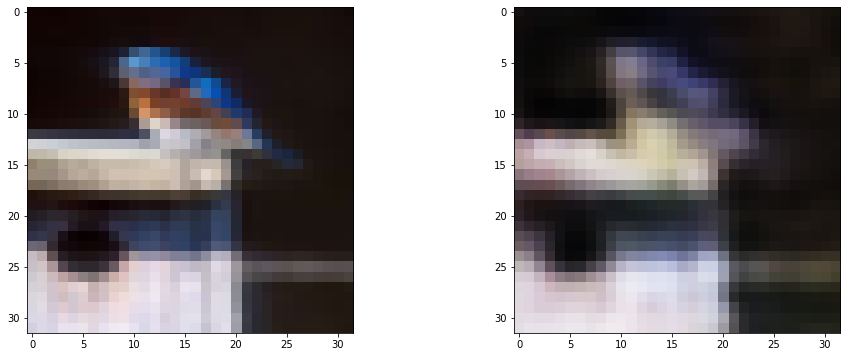

In [13]:
# Checking the performance of the autoencoder

img_idx = 1  # One can change the image index to compare different images with their reconstructed version

img = ''

from_test = False
if from_test:
    img = vae.predict(bird_images_test[img_idx].reshape(1, 32, 32, 3))
else:
    img = vae.predict(bird_images[img_idx].reshape(1, 32, 32, 3))
img = img[0]

fig, img_array = plt.subplots(1, 2)
fig.set_size_inches(16, 6)

if from_test:
    img_array[0].imshow(bird_images_test[img_idx])
else:
    img_array[0].imshow(bird_images[img_idx])
img_array[1].imshow(img)
plt.show()